# Overview
A common problem with digital transformation is to automatically digitize the documents, this is time consuming as someone manually data-entries the information, but as AI emerged, there are a lot of ways to do so without human involvement. Optical character recognition (OCR) is the process of reading the numbers, characters and words from images. We’d like you to tackle the problem of extracting text from images.


- It's not an obligatory thing to come up with the best accuracy, the sole target of this task is to capture your coding capabilities within the time spent in doing the task and your thought process when approaching this problem.


#Importing important libs

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob, random, math
from pathlib import Path
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import editdistance
import gradio as gr
#Downloading Dataset from Drive
import gdown
import zipfile
import os

# Config / Hyperparams

In [ ]:

DATA_DIR = "OCR_data"
IMG_H = 32
IMG_W = 256
BATCH_SIZE = 16
NUM_WORKERS = 2
EPOCHS = 8
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TS_PATH = "crnn_ts.pt"  # TorchScript path instead of ONNX
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
GRAD_CLIP = 5.0

#Dataload

In [ ]:
#make new folder to put the data in
!mkdir OCR_data

In [ ]:
#to download the Data
!pip install gdown

In [ ]:


# Google Drive file ID
file_id = '1lmz_vfsXJi7rMvLZ9jMAEQKa_iV1tH5w'
# Destination file name
output = 'updated_OCR_Text.zip'

# Download the file from Google Drive
gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', output, quiet=False)

# Path to the downloaded ZIP file
zip_path = 'updated_OCR_Text.zip'
# Path to extract the contents
extract_path = 'OCR_data'

# Create the extract path if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Contents extracted to: {extract_path}')


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1lmz_vfsXJi7rMvLZ9jMAEQKa_iV1tH5w
From (redirected): https://drive.google.com/uc?export=download&id=1lmz_vfsXJi7rMvLZ9jMAEQKa_iV1tH5w&confirm=t&uuid=77482f8d-fa2d-4458-b86b-eef90c46ea5e
To: /content/updated_OCR_Text.zip
100%|██████████| 285M/285M [00:01<00:00, 174MB/s]


Contents extracted to: OCR_data


In [ ]:
!cp /content/updated_OCR_Text.zip /content/drive/MyDrive/First Data Science project/updated_OCR_Text.zip

cp: target 'project/updated_OCR_Text.zip' is not a directory


#DataRead

In [ ]:
#Get list dirs of Data
path = 'OCR_data'
dir_list = os.listdir(path)

In [ ]:
#Take Unique names to relate image to label by names
dir_list = list(set([*map(lambda x: x.split(".")[0],dir_list)]))
len(dir_list)

19992

In [ ]:
#Reading Dataset images and Labels into lists
X = []
y = []
for i in dir_list:
    image_dir = os.path.join(path, i) + ".jpg"
    txt_dir = os.path.join(path, i) + ".txt"
    X.append(cv2.cvtColor(cv2.imread(image_dir), cv2.COLOR_BGR2RGB))
    y.append(open(txt_dir, 'r').read())

In [ ]:
#Function to display Images
import matplotlib.pyplot as plt
import numpy as np
import math

def display_images(images, titles=None):
    """
    Display a list of images.

    Parameters:
    images (list): List of images as NumPy arrays.
    titles (list): List of titles for the images (optional).
    """
    num_images = len(images)
    if titles and len(titles) != num_images:
        raise ValueError("The length of titles must match the number of images.")

    cols = 5
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 1 * rows))
    axes = axes.flatten()

    for ax in axes[num_images:]:
        ax.axis('off')

    for i, img in enumerate(images):
        ax = axes[i]
        ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

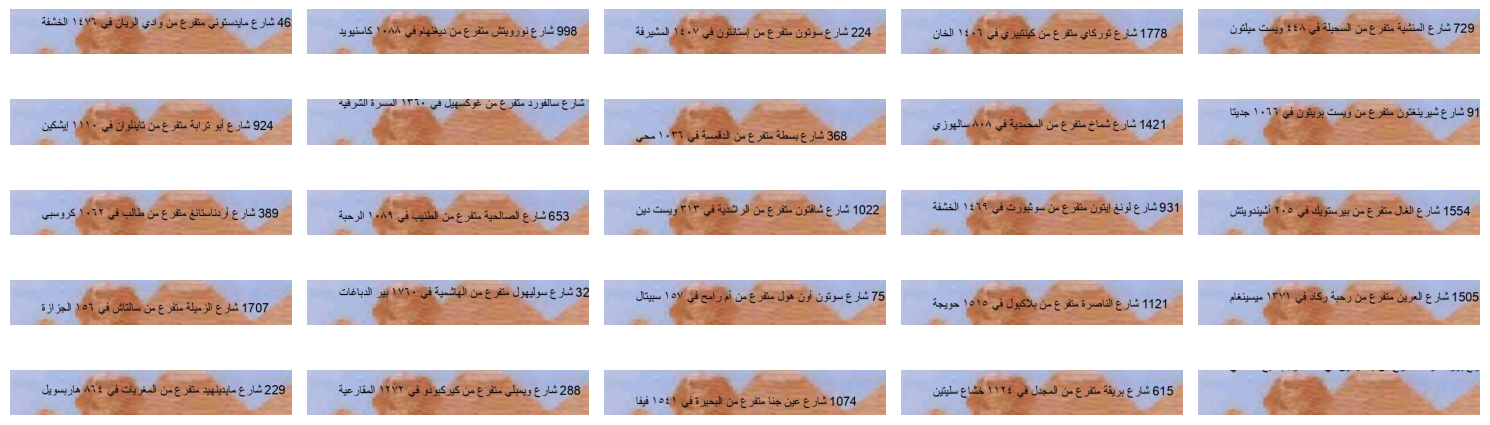

In [ ]:
display_images(X[:25])

In [ ]:
#converting list to numpy array and see the shape
X = np.array(X)
X.shape

(19992, 80, 500, 3)

In [ ]:
#convert txt data list to np.array
y = np.array(y)
y.shape

(19992,)

In [ ]:
#flattten all txt to Extract chars list
flatten_label = " ".join(y)
len(flatten_label)

1034693

In [ ]:
print(flatten_label[:100])

463 شارع مايدستوني متفرع من وادي الريان في ١٤٧٦ الخشفة 998 شارع نورويتش متفرع من ديغنهام في ١٠٨٨ كاس


In [ ]:
#Get char list
char_list = [*set(flatten_label)]
len(char_list)

64

In [ ]:
char_list

['1',
 'ذ',
 'a',
 'ز',
 'إ',
 '0',
 '5',
 'خ',
 '٨',
 '٦',
 'د',
 '2',
 '4',
 'b',
 'i',
 '٣',
 'و',
 '١',
 '٥',
 'ؤ',
 'ى',
 'ب',
 'غ',
 'ن',
 '7',
 '9',
 'ج',
 'ّ',
 'ص',
 'ا',
 'ء',
 'ت',
 'A',
 'م',
 'أ',
 '3',
 '٩',
 'ف',
 '٢',
 'c',
 'ش',
 'ل',
 '٠',
 'ح',
 'ق',
 'ú',
 'r',
 'ث',
 '٤',
 '8',
 'ظ',
 'ه',
 'ة',
 ' ',
 'ض',
 'ر',
 'ط',
 'ئ',
 'ع',
 '٧',
 'ي',
 'ك',
 '6',
 'س']

In [ ]:
!pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 || true
!pip install --quiet gradio editdistance

In [ ]:
# Read dataset & build charset
# -----------------------
files = sorted([os.path.basename(p) for p in glob.glob(os.path.join(DATA_DIR, "*"))])
stems = sorted(list({Path(f).stem for f in files}))
image_paths = []
labels = []
for s in stems:
    imgf = os.path.join(DATA_DIR, s + ".jpg")
    txtf = os.path.join(DATA_DIR, s + ".txt")
    if os.path.exists(imgf) and os.path.exists(txtf):
        image_paths.append(imgf)
        lab = open(txtf, "r", encoding="utf-8").read().strip()
        labels.append(lab)

assert len(image_paths) == len(labels) and len(labels) > 0, "No data found — check OCR_data folder."

In [ ]:
# Build character set
all_text = "\n".join(labels)
char_set = sorted(list(set([c for c in all_text if c not in ["\n","\r"]])))
char_to_idx = {ch: i+1 for i, ch in enumerate(char_set)}
idx_to_char = {i+1: ch for i, ch in enumerate(char_set)}
BLANK_IDX = 0
VOCAB_SIZE = len(char_set) + 1  # +1 for blank

print(f"Samples: {len(labels)}  |  Vocab size (incl blank): {VOCAB_SIZE}")
print("Example chars:", char_set[:40])


Samples: 19992  |  Vocab size (incl blank): 65
Example chars: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'a', 'b', 'c', 'i', 'r', 'ú', 'ء', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط']


#Data Preprocessing

In [ ]:
# Preprocessing helpers
# -----------------------
def read_image_rgb(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def preprocess_image_for_crnn(img, img_h=IMG_H, img_w=IMG_W):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape
    new_h = img_h
    new_w = max(1, int(w * (new_h / h)))
    resized = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_AREA)
    if new_w < img_w:
        pad = np.full((new_h, img_w - new_w), 255, dtype=np.uint8)
        resized = np.concatenate([resized, pad], axis=1)
    elif new_w > img_w:
        resized = resized[:, :img_w]
    arr = resized.astype(np.float32) / 255.0
    arr = (1.0 - arr)
    arr = (arr - 0.5) / 0.5
    arr = np.expand_dims(arr, 0)
    return arr

def text_to_labels(text):
    return [char_to_idx[c] for c in text if c in char_to_idx]

def labels_to_text(label_idxs: list):
    return "".join([idx_to_char[i] for i in label_idxs if i in idx_to_char])


#DataPreperation

In [ ]:
# -----------------------
# Dataset & collate
# -----------------------
class OCRDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = read_image_rgb(p)
        img_t = preprocess_image_for_crnn(img)
        label_str = self.labels[idx]
        label_idxs = torch.tensor(text_to_labels(label_str), dtype=torch.long)
        return {"image": torch.from_numpy(img_t).float(), "label": label_idxs, "label_str": label_str}

def collate_fn(batch):
    images = torch.stack([b["image"] for b in batch], dim=0)
    labels = [b["label"] for b in batch]
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels_concat = torch.cat(labels) if labels else torch.tensor([], dtype=torch.long)
    strs = [b["label_str"] for b in batch]
    return images, labels_concat, label_lengths, strs

#Modeling CRNN + CTC Loss function

In [ ]:
# -----------------------
# CRNN model (improved)
# -----------------------
class CRNN(nn.Module):
    def __init__(self, img_h=IMG_H, num_channels=1, num_classes=VOCAB_SIZE):
        super().__init__()
        # CNN feature extractor
        self.cnn = nn.Sequential(
        nn.Conv2d(num_channels, 64, 3, 1, 1), nn.ReLU(True),
        nn.MaxPool2d((2,2)),

        nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True),
        nn.MaxPool2d((2,2)),

        nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU(True),
        nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True),
        nn.MaxPool2d((2,1), (2,1)),

        nn.Conv2d(256, 512, 3, 1, 1), nn.ReLU(True),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
        nn.BatchNorm2d(512),
        nn.MaxPool2d((2,1), (2,1)),

        nn.Conv2d(512, 768, 3, 1, 1), nn.ReLU(True),  # increased filters
        nn.BatchNorm2d(768),
        nn.Conv2d(768, 768, 3, 1, 1), nn.ReLU(True),
        nn.BatchNorm2d(768),
        nn.MaxPool2d((2,1), (2,1)),

        nn.Conv2d(768, 512, 1, 1, 0), nn.ReLU(True)   # collapse height
)

        # Fully connected + dropout
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.2)
        )

        # Bidirectional LSTM
        self.bilstm = nn.LSTM(
            input_size=512,
            hidden_size=512,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        # Output layer
        self.embedding = nn.Linear(1024, num_classes)  # 512*2 because bidirectional

    def forward(self, x):
        # x: [B, 1, H, W]
        conv = self.cnn(x)
        b, c, h, w = conv.size()

        # Ensure height = 1
        if h != 1:
            conv = F.adaptive_avg_pool2d(conv, (1, w))
            b, c, h, w = conv.size()

        # Prepare for RNN: [B, W, C]
        conv = conv.squeeze(2).permute(0, 2, 1)
        feat = self.fc(conv)             # [B, W, 512]

        # Bidirectional LSTM
        rnn_out, _ = self.bilstm(feat)   # [B, W, 1024]

        # Final output
        logits = self.embedding(rnn_out) # [B, W, num_classes]
        out = logits.permute(1, 0, 2)    # [T=W, B, C] for CTC loss

        return out


In [ ]:
# -----------------------
# Prepare data loaders
# -----------------------
dataset = OCRDataset(image_paths, labels)
indices = list(range(len(dataset)))
random.shuffle(indices)
split = int(0.9 * len(indices))
train_set = torch.utils.data.Subset(dataset, indices[:split])
val_set = torch.utils.data.Subset(dataset, indices[split:])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS)

#Training

In [ ]:
model = CRNN(img_h=IMG_H, num_channels=1, num_classes=VOCAB_SIZE).to(DEVICE)
ctc_loss = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

def ctc_greedy_decode(logits_tensor):
    logp = F.log_softmax(logits_tensor, dim=2)
    preds = torch.argmax(logp, dim=2).permute(1,0)
    results = []
    for seq in preds:
        prev = BLANK_IDX
        out = []
        for p in seq.cpu().numpy().tolist():
            if p != prev and p != BLANK_IDX:
                if p in idx_to_char:
                    out.append(idx_to_char[p])
            prev = p
        results.append("".join(out))
    return results



In [ ]:
# Training / evaluation
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss, seen = 0.0, 0
    for images, labels_concat, label_lengths, strs in loader:
        images = images.to(device)
        labels_concat = labels_concat.to(device)
        label_lengths = label_lengths.to(device)
        optimizer.zero_grad()
        logits = model(images)
        T_steps, B, C = logits.size()
        if label_lengths.max().item() > T_steps:
            continue
        input_lengths = torch.full((B,), T_steps, dtype=torch.long).to(device)
        loss = loss_fn(F.log_softmax(logits, dim=2), labels_concat, input_lengths, label_lengths)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        total_loss += loss.item() * B
        seen += B
    return (total_loss / seen) if seen > 0 else 0.0

In [ ]:
# Run training
# -----------------------
print("Training on:", DEVICE)
best_val = float("inf")
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, ctc_loss, DEVICE)
    val_cer = evaluate(model, val_loader, DEVICE)
    scheduler.step()
    print(f"Epoch {epoch}/{EPOCHS} — TrainLoss: {train_loss:.6f} — ValCER: {val_cer:.4f}")
    if val_cer < best_val:
        best_val = val_cer
        torch.save(model.state_dict(), "crnn_best.pth")
        print("Saved best model.")

Training on: cuda
Epoch 1/8 — TrainLoss: 2.072540 — ValCER: 0.5074
Saved best model.
Epoch 2/8 — TrainLoss: 1.993677 — ValCER: 0.4722
Saved best model.
Epoch 3/8 — TrainLoss: 1.946352 — ValCER: 0.4654
Saved best model.
Epoch 4/8 — TrainLoss: 1.874025 — ValCER: 0.4647
Saved best model.
Epoch 5/8 — TrainLoss: 1.859726 — ValCER: 0.4642
Saved best model.
Epoch 6/8 — TrainLoss: 1.842607 — ValCER: 0.4678
Epoch 7/8 — TrainLoss: 1.834257 — ValCER: 0.4671
Epoch 8/8 — TrainLoss: 1.831285 — ValCER: 0.4606
Saved best model.


#Evaluation

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    total_cer, n = 0.0, 0
    with torch.no_grad():
        for images, labels_concat, label_lengths, strs in loader:
            images = images.to(device)
            logits = model(images)
            preds = ctc_greedy_decode(logits)
            for pred, gt in zip(preds, strs):
                total_cer += editdistance.eval(pred, gt) / max(1, len(gt))
                n += 1
    return total_cer / max(1, n)

#Model save to onnx

In [ ]:
# TorchScript export
# -----------------------
model_cpu = CRNN(img_h=IMG_H, num_channels=1, num_classes=VOCAB_SIZE)
model_cpu.load_state_dict(torch.load("crnn_best.pth", map_location="cpu"))
model_cpu.eval()
dummy_input = torch.randn(1,1,IMG_H,IMG_W)
traced_model = torch.jit.trace(model_cpu, dummy_input)
traced_model.save(TS_PATH)
print("TorchScript model saved to", TS_PATH)

/tmp/ipython-input-3908103185.py:59: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h != 1:


TorchScript model saved to crnn_ts.pt


In [ ]:
# Quick inference
# -----------------------
def infer_image(img_path, model_local, device=DEVICE):
    img = read_image_rgb(img_path)
    tensor = preprocess_image_for_crnn(img)
    t = torch.from_numpy(tensor).unsqueeze(0).to(device)
    model_local.eval()
    with torch.no_grad():
        logits = model_local(t)
        return ctc_greedy_decode(logits)[0]

#Gradio APP

In [ ]:
# Gradio demo using TorchScript
# -----------------------
traced_model_cpu = torch.jit.load(TS_PATH)
traced_model_cpu.eval()

def infer_from_array(img_array):
    if img_array.ndim == 2:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[2] == 4:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    tensor = preprocess_image_for_crnn(img_array)
    t = torch.from_numpy(tensor).unsqueeze(0)
    with torch.no_grad():
        logits = traced_model_cpu(t)
        return ctc_greedy_decode(logits)[0]

demo = gr.Interface(fn=infer_from_array,
                    inputs=gr.Image(type="numpy", label="Upload image (word/line)"),
                    outputs=gr.Textbox(label="Predicted text"),
                    title="CRNN OCR (printed text)")
print("Gradio demo ready. Run: demo.launch(share=True)")


Gradio demo ready. Run: demo.launch(share=True)


In [ ]:
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9f317fd3b5a026ba89.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


#Thanks

In [ ]:
# Thanks